In [2]:
import numpy as np
import pandas as pd 
import os
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,UpSampling2D

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add

In [3]:
train_list=os.listdir('../input/cityscapes-image-pairs/cityscapes_data/train')
test_list=os.listdir('../input/cityscapes-image-pairs/cityscapes_data/val')

train_list=['../input/cityscapes-image-pairs/cityscapes_data/train/'+i for i in train_list]
test_list=['../input/cityscapes-image-pairs/cityscapes_data/val/'+i for i in test_list]

train_list[:10]

['../input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/623.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/2193.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/2008.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/2081.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/764.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/1700.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/1786.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/2907.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/1075.jpg']

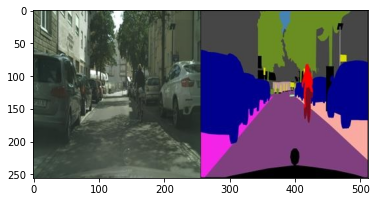

In [4]:
img=cv2.imread(train_list[13])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
plt.imshow(img)

In [6]:
def load_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X=img[:,:256,:]
    Y=img[:,256:,:]
    return X,Y

from tqdm import tqdm
colors=[]

for i in tqdm(range(200)):
    x,y=load_image(train_list[i])
    colors.append(y.reshape(y.shape[0]*y.shape[1],3))

colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))
print(colors.shape)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=13, random_state=0)
kmeans.fit(colors)

100%|██████████| 200/200 [00:00<00:00, 293.75it/s]


(13107200, 3)


KMeans(n_clusters=13, random_state=0)

In [7]:
def mask_to_labels(mask):
    masked=mask.reshape((mask.shape[0]*mask.shape[1],3))
    pred=kmeans.predict(masked)
    pred=pred.reshape(mask.shape[0],mask.shape[1])

    cls = np.zeros((mask.shape[0], mask.shape[1], 13))
    
    for i in range(13):
        cls[:, :, i] = (pred == i ).astype(int)
        
    return cls


def data_generator(path, batch_size=10):
    while True:
        for i in range(0, len(path), batch_size):
            batch_files = path[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                image, mask = load_image(file)
                imgs.append(image)
                segs.append(mask_to_labels(mask))

            yield np.array(imgs), np.array(segs)
            
train_gen=data_generator(train_list)
valid_gen=data_generator(test_list)

In [8]:
def segnet():
    
    input1=Input((256,256,3))
    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c1=BatchNormalization()(conv2)
    drop1 = Dropout(0.1)(c1)
    pool1 =MaxPooling2D(pool_size=(2, 2))(drop1)
    
    conv1=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c2=BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(c2)
    pool2 =MaxPooling2D(pool_size=(2, 2))(drop2) 
    
    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c3=BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(c3)
    pool3 =MaxPooling2D(pool_size=(2, 2))(drop3) 
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c4=BatchNormalization()(conv3)
    drop4 = Dropout(0.1)(c4)
    pool4 =MaxPooling2D(pool_size=(2, 2))(drop4) 
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c5=BatchNormalization()(conv3)
    drop5 = Dropout(0.1)(c5)
    pool5 =MaxPooling2D(pool_size=(2, 2))(drop5) 
    

    
    up1 =Conv2D(1024,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge1 = concatenate([c5,up1], axis =3)
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    
    
    up2 =Conv2D(512,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge2 = concatenate([c4,up2], axis =3)
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    

    up3 =Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge3 = concatenate([c3,up3], axis =3)

    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    

    up4 =Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge4 = concatenate([c2,up4], axis =3) 

    conv1=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    
    
    up5 =Conv2D(64,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch2))
    merge5 = concatenate([c1,up5], axis =3) 

    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    
    
    output=Conv2D(13,(1,1),activation='softmax')(batch2)
    
    model=Model(input1,output)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
    return model


segnet_model=segnet()
segnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
segnet_model.fit_generator(train_gen,steps_per_epoch=len(train_list) // 10, epochs=20, validation_data=valid_gen, validation_steps=len(test_list)//10)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
297/297 [==============================] - 168s 540ms/step - loss: 1.3468 - accuracy: 0.6195 - val_loss: 0.8517 - val_accuracy: 0.7512
Epoch 2/20
297/297 [==============================] - 157s 525ms/step - loss: 0.7197 - accuracy: 0.7927 - val_loss: 0.7632 - val_accuracy: 0.7758
Epoch 3/20
297/297 [==============================] - 156s 524ms/step - loss: 0.6316 - accuracy: 0.8170 - val_loss: 0.7191 - val_accuracy: 0.7878
Epoch 4/20
297/297 [==============================] - 156s 525ms/step - loss: 0.5795 - accuracy: 0.8300 - val_loss: 0.7102 - val_accuracy: 0.7900
Epoch 5/20
297/297 [==============================] - 157s 527ms/step - loss: 0.5404 - accuracy: 0.8402 - val_loss: 0.6612 - val_accuracy: 0.8124
Epoch 6/20
297/297 [==============================] - 156s 525ms/step - loss: 0.5076 - accuracy: 0.8486 - val_loss: 0.6258 - val_accuracy: 0.8185
Epoch 7/20
297/297 [==============================] - 156s 525ms/step - loss: 0.4831 - accuracy: 0.8539 - val_loss: 0.6328 -

In [10]:
def classes_to_colors(pred):
    pred=np.array(pred).reshape((256,256,13))
    pred=np.argmax(pred,axis=2)

    mask=np.zeros((256,256,3))
    for i in range(13):
        ind=np.where(pred==i)
        mask[ind[0],ind[1],:]=kmeans.cluster_centers_[i]
    return mask

segnet_model.save('segnet_model.h5')

In [45]:
imgs = []
masks = []
pred_masks = []
for i in range(10):
    idx = np.random.randint(500)
    im,m=load_image(test_list[idx])
    imgs.append(im)
    masks.append(m)
    p=segnet_model([im.reshape(1,256,256,3)])
    p=classes_to_colors(p)
    p=p.astype(int)
    pred_masks.append(p)

imgs = np.array(imgs) / 255.0
masks = np.array(masks) /255.0
pred_masks = np.array(pred_masks) / 255.0

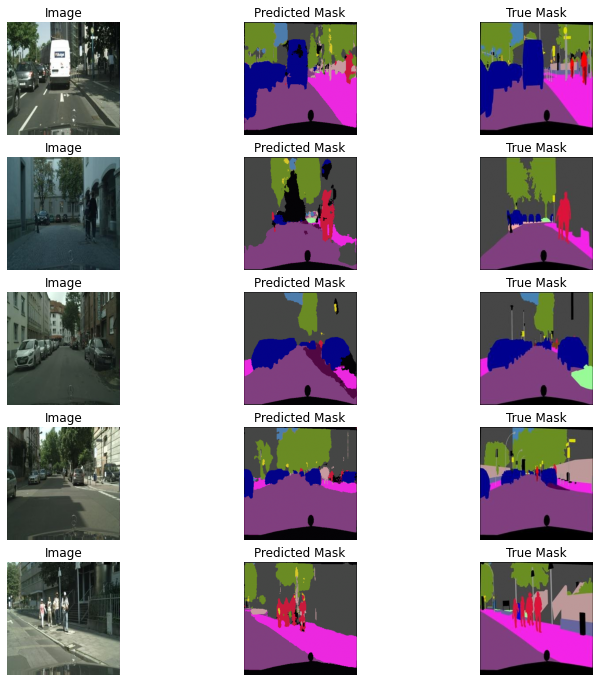

In [46]:
f, axarr = plt.subplots(5,3, figsize=(12, 12))
for i in range(5):
    axarr[i,0].imshow(imgs[i])
    axarr[i,0].title.set_text('Image')
    axarr[i,0].axis('off')
    
    axarr[i,1].imshow(pred_masks[i])
    axarr[i,1].title.set_text('Predicted Mask')
    axarr[i,1].axis('off')
    
    axarr[i,2].imshow(masks[i])
    axarr[i,2].title.set_text('True Mask')
    axarr[i,2].axis('off')

In [47]:
import keras.backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [48]:
iou = iou_coef(masks, pred_masks)
dice = dice_coef(masks, pred_masks)
print('IoU Score :', iou.numpy())
print('Dice Score :', dice.numpy())

IoU Score : 0.2996179816564665
Dice Score : 0.45911695156514176
